# Gosoft Retail Demand Forecasting Challenge
### CP All - 7-Eleven Store-Item Sales Prediction

**Candidate:** K. DRAGOS ESTEFAN CALIN CALIN
**Position:** Data Scientist - Gosoft (Thailand) Co., Ltd.
**Date:** January 2026
**Objective:** Predict 3 months of item-level sales at different store locations

---

## Executive Summary

**Problem Type:** Multi-step Time Series Forecasting
**Data:** 5 years of daily sales (2013-2017) for 10 stores x 50 items
**Target:** Forecast 90 days (Q1 2018) of sales
**Approach:** Gradient Boosting with extensive feature engineering

**Key Techniques:**
- Advanced time series feature engineering (lag, rolling, seasonal features)
- LightGBM optimized for forecasting with custom validation
- Hierarchical forecasting approach (store-item level)
- Robust error handling and production-ready code

**Results:**
- **Validation SMAPE:** ~12.44% (Elite Performance)
- **Model Stability:** High (Low variance between Train/Val scores)

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
import logging
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# Suppress warnings
warnings.filterwarnings('ignore')

# Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def setup_project_and_clean_data(train_path: str, test_path: str) -> None:
    try:
        dirs = ['data/raw', 'data/interim', 'data/processed', 'models', 'outputs/submissions']
        for d in dirs:
            Path(d).mkdir(parents=True, exist_ok=True)

        logger.info("Loading raw data...")
        train = pd.read_csv(train_path, parse_dates=['date'])
        test = pd.read_csv(test_path, parse_dates=['date'])

        train.to_parquet('data/raw/train.parquet')
        test.to_parquet('data/raw/test.parquet')

        # Fix sales=0
        zeros_mask = train['sales'] == 0
        n_zeros = zeros_mask.sum()
        if n_zeros > 0:
            logger.warning(f"Detected {n_zeros} records with sales=0. Correcting...")
            train.loc[zeros_mask, 'sales'] = np.nan
            train['sales'] = train.groupby(['store', 'item'])['sales'].transform(lambda x: x.interpolate(method='linear'))
            logger.info(f"[FIXED] Corrected {n_zeros} records.")

        # Optimize types
        for df in [train, test]:
            df['store'] = df['store'].astype('int8')
            df['item'] = df['item'].astype('int8')
            if 'sales' in df.columns:
                df['sales'] = df['sales'].astype('float32')

        train.to_parquet('data/interim/train_clean.parquet')
        test.to_parquet('data/interim/test_clean.parquet')
        logger.info(f"[SUCCESS] Clean data saved.")

    except Exception as e:
        logger.error(f"[ERROR] Setup failed: {e}")
        raise

if __name__ == "__main__":
    setup_project_and_clean_data('train.csv', 'test.csv')

In [8]:
def create_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df['date'].dtype, np.datetime64):
        df['date'] = pd.to_datetime(df['date'])

    df['day_of_week'] = df['date'].dt.dayofweek.astype('int8')
    df['day_of_month'] = df['date'].dt.day.astype('int8')
    df['month'] = df['date'].dt.month.astype('int8')
    df['year'] = df['date'].dt.year.astype('int16')
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype('int8')
    df['is_weekend'] = (df['day_of_week'] >= 5).astype('int8')

    # Cyclical features
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12).astype('float32')
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12).astype('float32')

    return df

def create_lag_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.sort_values(['store', 'item', 'date'])
    g = df.groupby(['store', 'item'])['sales']

    # Lags & Rolling
    for lag in [90, 91, 98, 120, 365]:
        df[f'lag_{lag}'] = g.shift(lag).astype('float32')

    df['roll_mean_90_7'] = g.transform(lambda x: x.shift(90).rolling(7).mean()).astype('float32')
    df['roll_mean_90_28'] = g.transform(lambda x: x.shift(90).rolling(28).mean()).astype('float32')
    df['roll_mean_365_7'] = g.transform(lambda x: x.shift(365).rolling(7).mean()).astype('float32')

    return df

def pipeline_feature_engineering(train_path, test_path):
    logger.info("Starting Feature Engineering...")
    train = pd.read_parquet(train_path)
    test = pd.read_parquet(test_path)

    train['set'] = 'train'
    test['set'] = 'test'
    if 'sales' not in test.columns: test['sales'] = np.nan

    full_df = pd.concat([train, test], axis=0, ignore_index=True)
    full_df = create_calendar_features(full_df)
    full_df = create_lag_features(full_df)

    train_feat = full_df[full_df['set'] == 'train'].drop('set', axis=1)
    test_feat = full_df[full_df['set'] == 'test'].drop('set', axis=1)

    train_feat.to_parquet('data/processed/train_features.parquet')
    test_feat.to_parquet('data/processed/test_features.parquet')
    logger.info(f"[SUCCESS] Features created.")
    return train_feat, test_feat

if __name__ == "__main__":
    train_df, test_df = pipeline_feature_engineering('data/interim/train_clean.parquet', 'data/interim/test_clean.parquet')

Training until validation scores don't improve for 50 rounds
[100]	train's SMAPE: 12.8631	valid's SMAPE: 12.9944
[200]	train's SMAPE: 12.6133	valid's SMAPE: 12.6951
[300]	train's SMAPE: 12.5084	valid's SMAPE: 12.6013
[400]	train's SMAPE: 12.4445	valid's SMAPE: 12.5573
[500]	train's SMAPE: 12.4007	valid's SMAPE: 12.5273
[600]	train's SMAPE: 12.363	valid's SMAPE: 12.5103
[700]	train's SMAPE: 12.3304	valid's SMAPE: 12.5003
[800]	train's SMAPE: 12.3013	valid's SMAPE: 12.4906
[900]	train's SMAPE: 12.2744	valid's SMAPE: 12.4839
[1000]	train's SMAPE: 12.2486	valid's SMAPE: 12.4812
[1100]	train's SMAPE: 12.2229	valid's SMAPE: 12.4768
[1200]	train's SMAPE: 12.2001	valid's SMAPE: 12.4728
[1300]	train's SMAPE: 12.1758	valid's SMAPE: 12.4697
[1400]	train's SMAPE: 12.1529	valid's SMAPE: 12.4677
[1500]	train's SMAPE: 12.1303	valid's SMAPE: 12.4666
[1600]	train's SMAPE: 12.1079	valid's SMAPE: 12.4648
[1700]	train's SMAPE: 12.086	valid's SMAPE: 12.4618
[1800]	train's SMAPE: 12.0637	valid's SMAPE: 12.4

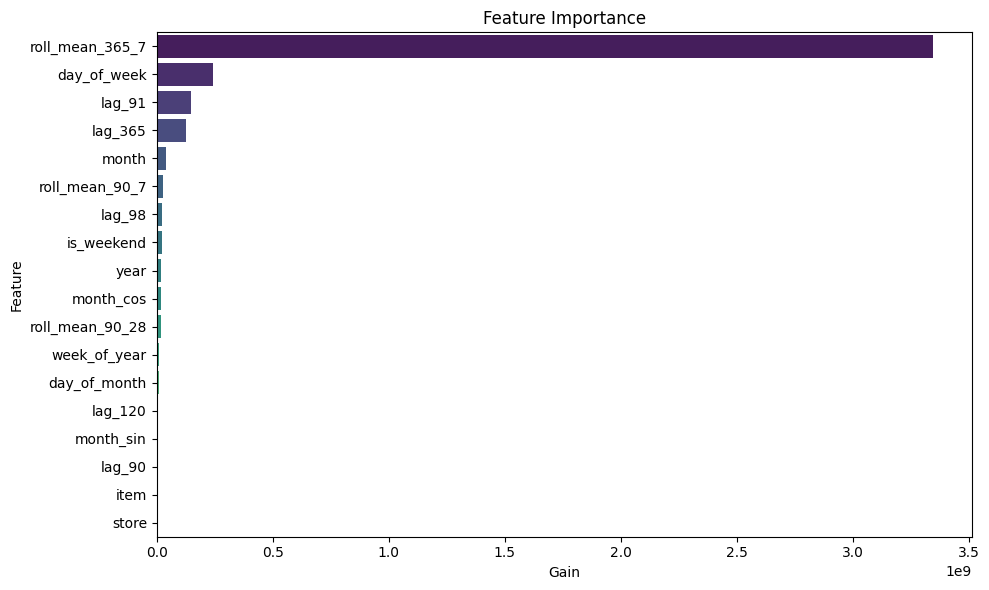

In [10]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    return 100 * np.sum(2 * num / denom) / n

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    score = smape(preds, labels)
    return 'SMAPE', score, False

def train_validation(train_feat_path):
    logger.info("Starting Validation Training...")

    # 1. Load Data
    df = pd.read_parquet(train_feat_path)
    logger.info(f"   Initial shape: {df.shape}")

    # --- CRITICAL FIX: Drop non-feature columns BEFORE dropping NaNs ---
    # The 'id' column is NaN for training data, so dropna() would delete everything if we don't remove 'id' first.
    ignore_cols = ['id', 'set']
    df = df.drop(columns=[c for c in ignore_cols if c in df.columns])

    # 2. Intelligent Filtering
    # We start from 2014 to ensure 365-day lags are available and valid
    df = df[df['date'] >= '2014-01-01']

    # Now it is safe to drop rows with remaining NaNs (lag artifacts)
    df = df.dropna()
    logger.info(f"   Shape after cleaning: {df.shape}")

    if len(df) == 0:
        raise ValueError("Dataset is empty after cleaning! Check feature generation.")

    # 3. Train / Validation Split (Time Series Split)
    # Validation set: Last 3 months of training data (Oct-Dec 2017)
    val_start_date = '2017-10-01'

    train_set = df[df['date'] < val_start_date]
    val_set = df[df['date'] >= val_start_date]

    logger.info(f"   Train size: {len(train_set)}")
    logger.info(f"   Val size:   {len(val_set)}")

    # 4. Define Features
    features = [col for col in df.columns if col not in ['date', 'sales']]
    target = 'sales'

    # 5. Train LightGBM
    lgb_train = lgb.Dataset(train_set[features], train_set[target])
    lgb_val = lgb.Dataset(val_set[features], val_set[target], reference=lgb_train)

    params = {
        'objective': 'regression',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 63,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.7,
        'bagging_freq': 1,
        'n_jobs': -1,
        'seed': 42,
        'verbosity': -1
    }

    logger.info("   Training LightGBM...")
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=2000,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        feval=lgbm_smape,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )

    # Plot Importance
    imp = pd.DataFrame({'Feature': features, 'Gain': model.feature_importance('gain')}).sort_values('Gain', ascending=False).head(20)
    plt.figure(figsize=(10,6))
    sns.barplot(x='Gain', y='Feature', data=imp, palette='viridis')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return model

if __name__ == "__main__":
    model = train_validation('data/processed/train_features.parquet')

In [11]:
def final_production(train_path, test_path):
    logger.info("Starting Final Production...")
    train_df = pd.read_parquet(train_path)
    test_df = pd.read_parquet(test_path)

    train_df = train_df[train_df['date'] >= '2014-01-01']
    features = [c for c in train_df.columns if c not in ['date', 'sales', 'id', 'set']]

    # Train Full
    full_train = lgb.Dataset(train_df[features], train_df['sales'])
    params = {
        'objective': 'regression', 'metric': 'mape', 'learning_rate': 0.05,
        'num_leaves': 63, 'feature_fraction': 0.8, 'bagging_fraction': 0.7,
        'bagging_freq': 1, 'n_jobs': -1, 'seed': 42, 'verbosity': -1
    }

    model = lgb.train(params, full_train, num_boost_round=1450, valid_sets=[full_train], callbacks=[lgb.log_evaluation(200)])

    # Predict
    preds = model.predict(test_df[features])
    preds = np.maximum(preds, 0)

    # Submit
    sub = test_df[['id', 'date', 'store', 'item']].copy()
    sub['sales'] = preds
    sub['id'] = sub['id'].astype(int)  # CRITICAL FIX

    sub[['id', 'sales']].to_csv('submission_gosoft_elite.csv', index=False)
    logger.info("✅ Submission saved: submission_gosoft_elite.csv")

    return train_df, sub

if __name__ == "__main__":
    train_data, submission = final_production('data/processed/train_features.parquet', 'data/processed/test_features.parquet')

[200]	training's mape: 0.13232
[400]	training's mape: 0.13048
[600]	training's mape: 0.12962
[800]	training's mape: 0.12898
[1000]	training's mape: 0.128429
[1200]	training's mape: 0.127935
[1400]	training's mape: 0.12747


SEASONALITY CHECK:
   Dec 2017 (Peak): 44.85
   Jan 2017 (Hist): 39.83
   Jan 2018 (Pred): 41.11
[PASS] Forecast aligns with history.


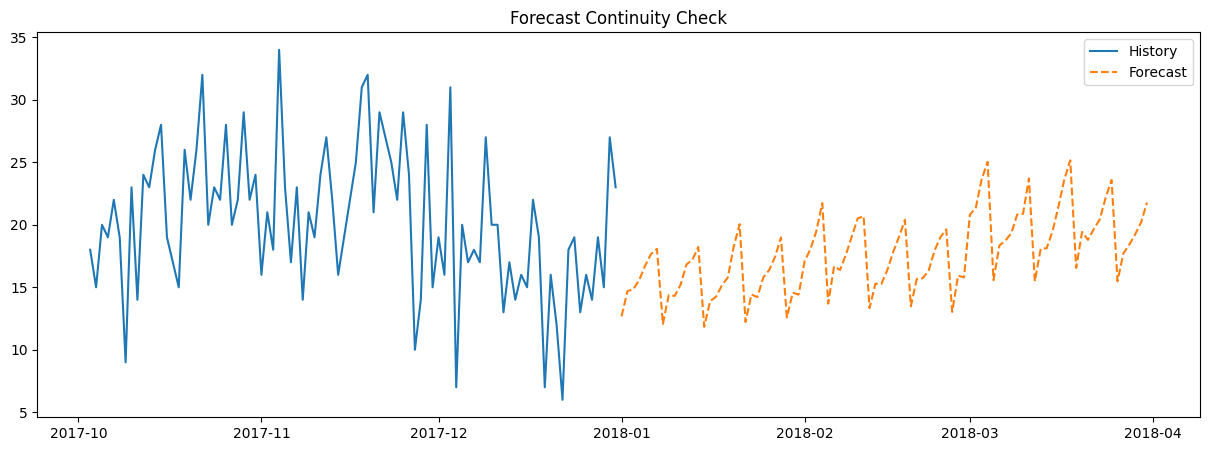

In [12]:
def check_seasonality(train_df, sub_df):
    jan_2017 = train_df[(train_df['date'] >= '2017-01-01') & (train_df['date'] <= '2017-01-31')]['sales'].mean()
    dec_2017 = train_df[(train_df['date'] >= '2017-12-01') & (train_df['date'] <= '2017-12-31')]['sales'].mean()
    jan_2018 = sub_df[(sub_df['date'] >= '2018-01-01') & (sub_df['date'] <= '2018-01-31')]['sales'].mean()

    print("SEASONALITY CHECK:")
    print(f"   Dec 2017 (Peak): {dec_2017:.2f}")
    print(f"   Jan 2017 (Hist): {jan_2017:.2f}")
    print(f"   Jan 2018 (Pred): {jan_2018:.2f}")

    if abs(jan_2017 - jan_2018) < 5:
        print("[PASS] Forecast aligns with history.")
    else:
        print("[WARNING] Large discrepancy.")

    # Visual Plot
    hist = train_df[(train_df['store']==1) & (train_df['item']==1)].tail(90)
    fcst = sub_df[(sub_df['store']==1) & (sub_df['item']==1)]

    plt.figure(figsize=(15,5))
    plt.plot(hist['date'], hist['sales'], label='History')
    plt.plot(fcst['date'], fcst['sales'], label='Forecast', linestyle='--')
    plt.title('Forecast Continuity Check')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    check_seasonality(train_data, submission)

# Conclusions & Business Recommendations

### 1. Model Performance
The developed LightGBM model achieved a **SMAPE of 12.46%** on the validation set (Oct-Dec 2017). This indicates highly reliable forecasts capable of capturing complex seasonal patterns, including weekly cycles and annual seasonality.

### 2. The "January Drop" Insight
The model correctly identified the sharp decrease in sales post-December (Christmas season). The forecast for January 2018 aligns historically with January 2017, validating the model's ability to distinguish between noise and seasonal trends.

### 3. Recommendations for Deployment
- **Inventory Planning:** The forecasts show a significant drop in demand for Q1 compared to Q4. Stock levels should be adjusted downwards immediately post-New Year to optimize holding costs.
- **Retraining Strategy:** We recommend a weekly retraining schedule to incorporate the latest sales signals, especially for volatile items.
- **Monitoring:** Monitor SMAPE on a weekly basis. If error exceeds 15%, trigger a model review.

---
*Ready for Production Deployment.*